In [30]:
# Utilities
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input
import numpy as np
import xgboost as xgb
from keras.applications import ResNet50,VGG19, MobileNetV2, DenseNet121
from keras import metrics
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.layers import GlobalAveragePooling2D, Concatenate, Dense

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Veri yollarını belirtin
data_dir = "/content/drive/My Drive/kaan-oral_cancer/Oral_cancer_histopathological_images"  # Veri klasörünün kök dizini
class_names = ["0", "1"]  # Sınıf adları

Mounted at /content/drive


In [26]:
import os

# Sınıf adları
class_names = ["0", "1"]

# Toplam etiket ve resim sayıları
total_labels = 0
total_images = 0

# Her sınıf için etiket ve resim sayılarını hesapla
for class_name in class_names:
    class_dir = os.path.join(data_dir, class_name)
    class_labels = len(os.listdir(class_dir))
    class_images = len([f for f in os.listdir(class_dir) if f.endswith('.png')])  # .png uzantılı dosyaları say

    total_labels += class_labels
    total_images += class_images

    print(f"Sınıf: {class_name}, Etiket Sayısı: {class_labels}, Resim Sayısı: {class_images}")

# Toplam etiket ve resim sayılarını yazdır
print(f"\nToplam Etiket Sayısı: {total_labels}")
print(f"Toplam Resim Sayısı: {total_images}")


Sınıf: 0, Etiket Sayısı: 146, Resim Sayısı: 146
Sınıf: 1, Etiket Sayısı: 91, Resim Sayısı: 91

Toplam Etiket Sayısı: 237
Toplam Resim Sayısı: 237


In [31]:
# Data and Labels Collection
data = []
labels = []

for class_name in class_names:
    class_dir = os.path.join(data_dir, class_name)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        img = cv2.imread(img_path)
        data.append(cv2.resize(img, (224, 224)))
        labels.append(class_name)


In [32]:

# Convert to NumPy arrays
data = np.array(data)
labels = np.array(labels)

# Split data into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=42)

train_labels = train_labels.astype(int)
test_labels = test_labels.astype(int)

from keras.utils import to_categorical

# Convert training labels to one-hot encoding
train_labels_onehot = to_categorical(train_labels, num_classes=2)

# Convert testing labels to one-hot encoding
test_labels_onehot = to_categorical(test_labels, num_classes=2)

# **3li ensemble**

In [33]:


# Modelin tanımlanması
input_shape = (224, 224, 3)

# VGG19 tabanı
vgg19_base = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)
vgg19_output = vgg19_base.output
vgg19_output = GlobalAveragePooling2D()(vgg19_output)

# MobileNetV2 tabanı
mobilenet_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
mobilenet_output = mobilenet_base.output
mobilenet_output = GlobalAveragePooling2D()(mobilenet_output)

# DenseNet121 tabanı
densenet_base = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)
densenet_output = densenet_base.output
densenet_output = GlobalAveragePooling2D()(densenet_output)

# Modellerin birleştirilmesi
merged = Concatenate()([vgg19_output, mobilenet_output, densenet_output])

# Fully connected katmanlar
dense_1 = Dense(256, activation='relu')(merged)
dense_2 = Dense(128, activation='relu')(dense_1)
output = Dense(3, activation='softmax')(dense_2)

# Modelin oluşturulması
model = Model(inputs=[vgg19_base.input, mobilenet_base.input, densenet_base.input], outputs=output)

# Modelin derlenmesi
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Modelin eğitimi
model.fit(train_data, train_labels, epochs=20, batch_size=32, validation_split=0.2)


Epoch 1/20


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 219, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "model_6" expects 3 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 224, 224, 3) dtype=uint8>]


In [ ]:
# Model Evaluation
evaluation = model.evaluate(test_data, test_labels_onehot)
test_accuracy = evaluation[1]
print("Test accuracy:", test_accuracy)

In [ ]:
from sklearn.metrics import classification_report

predictions = model.predict(test_data)

predicted_labels = np.argmax(predictions, axis=1)

true_labels = np.argmax(test_labels_onehot, axis=1)

class_report = classification_report(true_labels, predicted_labels)

# Print the classification report
print("Classification Report:")
print(class_report)


# **Gerisi normal**

In [ ]:
train_data_scaled = train_data / 255.0
test_data_scaled = test_data / 255.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 3.0 MB/s eta 0:00:00


In [ ]:
import os
import cv2
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.applications import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input
from keras.models import Model

In [ ]:


# ResNet50 modelinin yüklenmesi (son katmanlar hariç)
base_model = ResNet50(weights='imagenet', include_top=False)
model = Model(inputs=base_model.input, outputs=base_model.output)

# Veri ve etiketlerin toplanması
data = []
labels = []

for class_name in class_names:
    class_dir = os.path.join(data_dir, class_name)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        img = image.load_img(img_path, target_size=(224, 224))
        img_data = image.img_to_array(img)
        img_data = np.expand_dims(img_data, axis=0)
        img_data = preprocess_input(img_data)
        features = model.predict(img_data)
        data.append(features.flatten())
        labels.append(class_name)

# Veri ve etiketlerin numpy dizilerine dönüştürülmesi
X = np.array(data)
y = np.array(labels)

# Eğitim ve test verilerinin bölünmesi
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)




1/1 [==============================] - 0s 355ms/step


In [ ]:
from sklearn.preprocessing import LabelEncoder

# LabelEncoder nesnesinin oluşturulması ve uygulanması
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)


In [ ]:
# XGBoost modelinin eğitilmesi
xgb_model = xgb.XGBClassifier(learning_rate=0.1, max_depth=5, n_estimators=100)

xgb_model.fit(X_train, y_train_encoded)




XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
# Modelin tahminleri ve doğruluk değerlendirmesi
y_pred = xgb_model.predict(X_test)
accuracy = accuracy_score(y_test_encoded, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.7708333333333334


In [ ]:
from sklearn.metrics import confusion_matrix

# Confusion matrix'in hesaplanması
conf_matrix = confusion_matrix(y_test_encoded, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[26  5]
 [ 6 11]]


In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# XGBoost modeli
xgb_model = XGBClassifier()

# Parametreler ve aralıkları
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
}

# GridSearchCV nesnesinin oluşturulması
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5)

# Grid aramasının gerçekleştirilmesi
grid_search.fit(X_train, y_train_encoded)

# En iyi parametreler ve modelin alınması
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("En iyi parametreler:", best_params)
print("En iyi model:", best_model)


En iyi parametreler: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
En iyi model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

# En iyi modelin eğitimi
best_model.fit(X_train, y_train_encoded)

# Test verisi üzerinde tahmin yapılması
y_pred = best_model.predict(X_test)

# Accuracy değerinin hesaplanması
accuracy = accuracy_score(y_test_encoded, y_pred)
print("Accuracy:", accuracy)

# Confusion matrix'in hesaplanması
conf_matrix = confusion_matrix(y_test_encoded, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


In [ ]:
# ResNet-50 Model
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Freeze layers
#for layer in resnet_model.layers:
#    layer.trainable = False

# Build Model
model = Sequential()
model.add(resnet_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(units=256, activation='relu'))
model.add(Dense(units=2, activation='sigmoid'))

In [ ]:
# Compile Model
model.compile(optimizer=Adamax(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

checkpoint = ModelCheckpoint("best_model_resneet_weights.h5",
                             monitor='val_acc',  # Kaydetme kriteri olarak doğruluk metriğini kullanın
                             verbose=1,
                             save_best_only=True,    # Sadece en iyi performansı gösteren ağırlıkları kaydedin
                             mode='max')

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, mode='auto', factor=0.3, min_lr=0.000001)
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# Train Model
history = model.fit(train_data, train_labels_onehot, epochs=100, validation_split=0.2, callbacks=[reduce_lr, early_stopping, checkpoint])


Epoch 1/100
5/5 [==============================] - ETA: 0s - loss: 0.6790 - accuracy: 0.7351

5/5 [==============================] - 18s 640ms/step - loss: 0.6790 - accuracy: 0.7351 - val_loss: 8.4780 - val_accuracy: 0.5789 - lr: 0.0010
Epoch 2/100
5/5 [==============================] - ETA: 0s - loss: 0.2019 - accuracy: 0.9404

5/5 [==============================] - 2s 345ms/step - loss: 0.2019 - accuracy: 0.9404 - val_loss: 37.1652 - val_accuracy: 0.5789 - lr: 0.0010
Epoch 3/100
5/5 [==============================] - ETA: 0s - loss: 0.1724 - accuracy: 0.9735

5/5 [==============================] - 2s 349ms/step - loss: 0.1724 - accuracy: 0.9735 - val_loss: 38.5865 - val_accuracy: 0.5789 - lr: 0.0010
Epoch 4/100
5/5 [==============================] - ETA: 0s - loss: 0.0626 - accuracy: 0.9735

5/5 [==============================] - 2s 345ms/step - loss: 0.0626 - accuracy: 0.9735 - val_loss: 16.1422 - val_accuracy: 0.7105 - lr: 0.0010
Epoch 5/100
5/5 [==============================] - ETA: 0s - loss: 0.0244 - accuracy: 1.0000

5/5 [==============================] - 2s 347ms/step - loss: 0.0244 - accuracy: 1.0000 - val_loss: 12.7106 - val_accuracy: 0.6579 - lr: 3.0000e-04
Epoch 6/100
5/5 [==============================] - ETA: 0s - loss: 0.0186 - accuracy: 1.0000

5/5 [==============================] - 2s 346ms/step - loss: 0.0186 - accuracy: 1.0000 - val_loss: 10.3814 - val_accuracy: 0.6579 - lr: 3.0000e-04
Epoch 7/100
5/5 [==============================] - ETA: 0s - loss: 0.0120 - accuracy: 1.0000

5/5 [==============================] - 2s 355ms/step - loss: 0.0120 - accuracy: 1.0000 - val_loss: 8.7515 - val_accuracy: 0.6579 - lr: 3.0000e-04
Epoch 8/100
5/5 [==============================] - ETA: 0s - loss: 0.0090 - accuracy: 1.0000

5/5 [==============================] - 2s 375ms/step - loss: 0.0090 - accuracy: 1.0000 - val_loss: 7.3822 - val_accuracy: 0.6579 - lr: 9.0000e-05
Epoch 9/100
5/5 [==============================] - ETA: 0s - loss: 0.0184 - accuracy: 0.9934

5/5 [==============================] - 2s 368ms/step - loss: 0.0184 - accuracy: 0.9934 - val_loss: 6.1615 - val_accuracy: 0.6579 - lr: 9.0000e-05
Epoch 10/100
5/5 [==============================] - ETA: 0s - loss: 0.0328 - accuracy: 0.9801

5/5 [==============================] - 2s 384ms/step - loss: 0.0328 - accuracy: 0.9801 - val_loss: 5.2296 - val_accuracy: 0.6579 - lr: 9.0000e-05
Epoch 11/100
5/5 [==============================] - ETA: 0s - loss: 0.0157 - accuracy: 1.0000

5/5 [==============================] - 2s 357ms/step - loss: 0.0157 - accuracy: 1.0000 - val_loss: 4.3260 - val_accuracy: 0.6842 - lr: 9.0000e-05
Epoch 12/100
5/5 [==============================] - ETA: 0s - loss: 0.0048 - accuracy: 1.0000

5/5 [==============================] - 2s 365ms/step - loss: 0.0048 - accuracy: 1.0000 - val_loss: 3.6285 - val_accuracy: 0.7105 - lr: 9.0000e-05
Epoch 13/100
5/5 [==============================] - ETA: 0s - loss: 0.0118 - accuracy: 1.0000

5/5 [==============================] - 2s 363ms/step - loss: 0.0118 - accuracy: 1.0000 - val_loss: 3.1475 - val_accuracy: 0.7368 - lr: 9.0000e-05
Epoch 14/100
5/5 [==============================] - ETA: 0s - loss: 0.0183 - accuracy: 0.9934

5/5 [==============================] - 2s 358ms/step - loss: 0.0183 - accuracy: 0.9934 - val_loss: 2.8094 - val_accuracy: 0.7632 - lr: 9.0000e-05
Epoch 15/100
5/5 [==============================] - ETA: 0s - loss: 0.0038 - accuracy: 1.0000

5/5 [==============================] - 2s 370ms/step - loss: 0.0038 - accuracy: 1.0000 - val_loss: 2.5153 - val_accuracy: 0.7632 - lr: 9.0000e-05
Epoch 16/100
5/5 [==============================] - ETA: 0s - loss: 0.0102 - accuracy: 0.9934

5/5 [==============================] - 2s 369ms/step - loss: 0.0102 - accuracy: 0.9934 - val_loss: 2.2417 - val_accuracy: 0.7632 - lr: 9.0000e-05
Epoch 17/100
5/5 [==============================] - ETA: 0s - loss: 0.0056 - accuracy: 1.0000

5/5 [==============================] - 2s 365ms/step - loss: 0.0056 - accuracy: 1.0000 - val_loss: 1.9933 - val_accuracy: 0.7632 - lr: 9.0000e-05
Epoch 18/100
5/5 [==============================] - ETA: 0s - loss: 0.0043 - accuracy: 1.0000

5/5 [==============================] - 2s 366ms/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 1.7980 - val_accuracy: 0.7632 - lr: 9.0000e-05
Epoch 19/100
5/5 [==============================] - ETA: 0s - loss: 0.0044 - accuracy: 1.0000

5/5 [==============================] - 2s 368ms/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 1.6487 - val_accuracy: 0.7368 - lr: 9.0000e-05
Epoch 20/100
5/5 [==============================] - ETA: 0s - loss: 0.0030 - accuracy: 1.0000

5/5 [==============================] - 2s 357ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 1.5457 - val_accuracy: 0.7895 - lr: 9.0000e-05
Epoch 21/100
5/5 [==============================] - ETA: 0s - loss: 0.0021 - accuracy: 1.0000

5/5 [==============================] - 2s 360ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 1.4914 - val_accuracy: 0.7895 - lr: 9.0000e-05
Epoch 22/100
5/5 [==============================] - ETA: 0s - loss: 0.0025 - accuracy: 1.0000

5/5 [==============================] - 2s 360ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 1.4467 - val_accuracy: 0.7895 - lr: 9.0000e-05
Epoch 23/100
5/5 [==============================] - ETA: 0s - loss: 0.0047 - accuracy: 1.0000

5/5 [==============================] - 2s 363ms/step - loss: 0.0047 - accuracy: 1.0000 - val_loss: 1.4167 - val_accuracy: 0.7895 - lr: 9.0000e-05
Epoch 24/100
5/5 [==============================] - ETA: 0s - loss: 0.0022 - accuracy: 1.0000

5/5 [==============================] - 2s 357ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 1.3837 - val_accuracy: 0.7895 - lr: 9.0000e-05
Epoch 25/100
5/5 [==============================] - ETA: 0s - loss: 0.0023 - accuracy: 1.0000

5/5 [==============================] - 2s 366ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 1.3482 - val_accuracy: 0.7895 - lr: 9.0000e-05
Epoch 26/100
5/5 [==============================] - ETA: 0s - loss: 0.0054 - accuracy: 1.0000

5/5 [==============================] - 2s 358ms/step - loss: 0.0054 - accuracy: 1.0000 - val_loss: 1.3141 - val_accuracy: 0.7895 - lr: 9.0000e-05
Epoch 27/100
5/5 [==============================] - ETA: 0s - loss: 0.0023 - accuracy: 1.0000

5/5 [==============================] - 2s 360ms/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 1.2754 - val_accuracy: 0.7895 - lr: 9.0000e-05
Epoch 28/100
5/5 [==============================] - ETA: 0s - loss: 0.0054 - accuracy: 1.0000

5/5 [==============================] - 2s 356ms/step - loss: 0.0054 - accuracy: 1.0000 - val_loss: 1.2457 - val_accuracy: 0.7895 - lr: 9.0000e-05
Epoch 29/100
5/5 [==============================] - ETA: 0s - loss: 0.0027 - accuracy: 1.0000

5/5 [==============================] - 2s 367ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 1.2172 - val_accuracy: 0.7895 - lr: 9.0000e-05
Epoch 30/100
5/5 [==============================] - ETA: 0s - loss: 0.0017 - accuracy: 1.0000

5/5 [==============================] - 2s 356ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 1.1836 - val_accuracy: 0.7895 - lr: 9.0000e-05
Epoch 31/100
5/5 [==============================] - ETA: 0s - loss: 0.0019 - accuracy: 1.0000

5/5 [==============================] - 2s 355ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 1.1519 - val_accuracy: 0.7895 - lr: 9.0000e-05
Epoch 32/100
5/5 [==============================] - ETA: 0s - loss: 0.0268 - accuracy: 0.9934

5/5 [==============================] - 2s 356ms/step - loss: 0.0268 - accuracy: 0.9934 - val_loss: 1.1129 - val_accuracy: 0.7895 - lr: 9.0000e-05
Epoch 33/100
5/5 [==============================] - ETA: 0s - loss: 0.0025 - accuracy: 1.0000

5/5 [==============================] - 2s 360ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 1.0524 - val_accuracy: 0.7895 - lr: 9.0000e-05
Epoch 34/100
5/5 [==============================] - ETA: 0s - loss: 0.0046 - accuracy: 1.0000

5/5 [==============================] - 2s 359ms/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 1.0207 - val_accuracy: 0.7895 - lr: 9.0000e-05
Epoch 35/100
5/5 [==============================] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

5/5 [==============================] - 2s 362ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.9899 - val_accuracy: 0.7895 - lr: 9.0000e-05
Epoch 36/100
5/5 [==============================] - ETA: 0s - loss: 0.0022 - accuracy: 1.0000

5/5 [==============================] - 2s 350ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.9667 - val_accuracy: 0.7895 - lr: 9.0000e-05
Epoch 37/100
5/5 [==============================] - ETA: 0s - loss: 0.0018 - accuracy: 1.0000

5/5 [==============================] - 2s 369ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.9516 - val_accuracy: 0.7895 - lr: 9.0000e-05
Epoch 38/100
5/5 [==============================] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

5/5 [==============================] - 2s 366ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.9372 - val_accuracy: 0.7895 - lr: 9.0000e-05
Epoch 39/100
5/5 [==============================] - ETA: 0s - loss: 0.0020 - accuracy: 1.0000

5/5 [==============================] - 2s 371ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.9230 - val_accuracy: 0.7895 - lr: 9.0000e-05
Epoch 40/100
5/5 [==============================] - ETA: 0s - loss: 0.0050 - accuracy: 1.0000

5/5 [==============================] - 2s 362ms/step - loss: 0.0050 - accuracy: 1.0000 - val_loss: 0.9089 - val_accuracy: 0.7895 - lr: 9.0000e-05
Epoch 41/100
5/5 [==============================] - ETA: 0s - loss: 0.0014 - accuracy: 1.0000

5/5 [==============================] - 2s 365ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.8961 - val_accuracy: 0.7632 - lr: 9.0000e-05
Epoch 42/100
5/5 [==============================] - ETA: 0s - loss: 0.0022 - accuracy: 1.0000

5/5 [==============================] - 2s 356ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.8827 - val_accuracy: 0.7632 - lr: 9.0000e-05
Epoch 43/100
5/5 [==============================] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000

5/5 [==============================] - 2s 363ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.8679 - val_accuracy: 0.7632 - lr: 9.0000e-05
Epoch 44/100
5/5 [==============================] - ETA: 0s - loss: 0.0024 - accuracy: 1.0000

5/5 [==============================] - 2s 360ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.8578 - val_accuracy: 0.7632 - lr: 9.0000e-05
Epoch 45/100
5/5 [==============================] - ETA: 0s - loss: 0.0024 - accuracy: 1.0000

5/5 [==============================] - 2s 357ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.8477 - val_accuracy: 0.7632 - lr: 9.0000e-05
Epoch 46/100
5/5 [==============================] - ETA: 0s - loss: 0.0017 - accuracy: 1.0000

5/5 [==============================] - 2s 361ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.8351 - val_accuracy: 0.7632 - lr: 9.0000e-05
Epoch 47/100
5/5 [==============================] - ETA: 0s - loss: 0.0036 - accuracy: 1.0000

5/5 [==============================] - 2s 361ms/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.8258 - val_accuracy: 0.7632 - lr: 9.0000e-05
Epoch 48/100
5/5 [==============================] - ETA: 0s - loss: 0.0013 - accuracy: 1.0000

5/5 [==============================] - 2s 360ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.8141 - val_accuracy: 0.7632 - lr: 9.0000e-05
Epoch 49/100
5/5 [==============================] - ETA: 0s - loss: 0.0017 - accuracy: 1.0000

5/5 [==============================] - 2s 358ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.8053 - val_accuracy: 0.7632 - lr: 9.0000e-05
Epoch 50/100
5/5 [==============================] - ETA: 0s - loss: 8.7963e-04 - accuracy: 1.0000

5/5 [==============================] - 2s 359ms/step - loss: 8.7963e-04 - accuracy: 1.0000 - val_loss: 0.7983 - val_accuracy: 0.7632 - lr: 9.0000e-05
Epoch 51/100
5/5 [==============================] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000

5/5 [==============================] - 2s 357ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.7901 - val_accuracy: 0.7632 - lr: 9.0000e-05
Epoch 52/100
5/5 [==============================] - ETA: 0s - loss: 0.0024 - accuracy: 1.0000

5/5 [==============================] - 2s 356ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.7849 - val_accuracy: 0.7632 - lr: 9.0000e-05
Epoch 53/100
5/5 [==============================] - ETA: 0s - loss: 9.1025e-04 - accuracy: 1.0000

5/5 [==============================] - 2s 357ms/step - loss: 9.1025e-04 - accuracy: 1.0000 - val_loss: 0.7764 - val_accuracy: 0.7632 - lr: 9.0000e-05
Epoch 54/100
5/5 [==============================] - ETA: 0s - loss: 6.6599e-04 - accuracy: 1.0000

5/5 [==============================] - 2s 359ms/step - loss: 6.6599e-04 - accuracy: 1.0000 - val_loss: 0.7681 - val_accuracy: 0.7632 - lr: 9.0000e-05
Epoch 55/100
5/5 [==============================] - ETA: 0s - loss: 0.0032 - accuracy: 1.0000

5/5 [==============================] - 2s 370ms/step - loss: 0.0032 - accuracy: 1.0000 - val_loss: 0.7670 - val_accuracy: 0.7632 - lr: 9.0000e-05
Epoch 56/100
5/5 [==============================] - ETA: 0s - loss: 7.3933e-04 - accuracy: 1.0000

5/5 [==============================] - 2s 362ms/step - loss: 7.3933e-04 - accuracy: 1.0000 - val_loss: 0.7630 - val_accuracy: 0.7632 - lr: 9.0000e-05
Epoch 57/100
5/5 [==============================] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000

5/5 [==============================] - 2s 360ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.7597 - val_accuracy: 0.7632 - lr: 9.0000e-05
Epoch 58/100
5/5 [==============================] - ETA: 0s - loss: 0.0019 - accuracy: 1.0000

5/5 [==============================] - 2s 365ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.7576 - val_accuracy: 0.7895 - lr: 9.0000e-05
Epoch 59/100
5/5 [==============================] - ETA: 0s - loss: 9.7756e-04 - accuracy: 1.0000

5/5 [==============================] - 2s 368ms/step - loss: 9.7756e-04 - accuracy: 1.0000 - val_loss: 0.7539 - val_accuracy: 0.7895 - lr: 9.0000e-05
Epoch 60/100
5/5 [==============================] - ETA: 0s - loss: 0.0022 - accuracy: 1.0000

5/5 [==============================] - 2s 366ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.7501 - val_accuracy: 0.7895 - lr: 9.0000e-05
Epoch 61/100
5/5 [==============================] - ETA: 0s - loss: 8.4008e-04 - accuracy: 1.0000

5/5 [==============================] - 2s 362ms/step - loss: 8.4008e-04 - accuracy: 1.0000 - val_loss: 0.7475 - val_accuracy: 0.7895 - lr: 9.0000e-05
Epoch 62/100
5/5 [==============================] - ETA: 0s - loss: 8.4412e-04 - accuracy: 1.0000

5/5 [==============================] - 2s 363ms/step - loss: 8.4412e-04 - accuracy: 1.0000 - val_loss: 0.7456 - val_accuracy: 0.7895 - lr: 9.0000e-05
Epoch 63/100
5/5 [==============================] - ETA: 0s - loss: 0.0025 - accuracy: 1.0000

5/5 [==============================] - 2s 364ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.7437 - val_accuracy: 0.7895 - lr: 9.0000e-05
Epoch 64/100
5/5 [==============================] - ETA: 0s - loss: 7.7394e-04 - accuracy: 1.0000

5/5 [==============================] - 2s 364ms/step - loss: 7.7394e-04 - accuracy: 1.0000 - val_loss: 0.7423 - val_accuracy: 0.7895 - lr: 9.0000e-05
Epoch 65/100
5/5 [==============================] - ETA: 0s - loss: 9.1340e-04 - accuracy: 1.0000

5/5 [==============================] - 2s 366ms/step - loss: 9.1340e-04 - accuracy: 1.0000 - val_loss: 0.7391 - val_accuracy: 0.7895 - lr: 9.0000e-05
Epoch 66/100
5/5 [==============================] - ETA: 0s - loss: 0.0025 - accuracy: 1.0000

5/5 [==============================] - 2s 360ms/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.7382 - val_accuracy: 0.7895 - lr: 9.0000e-05
Epoch 67/100
5/5 [==============================] - ETA: 0s - loss: 0.0016 - accuracy: 1.0000

5/5 [==============================] - 2s 362ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.7365 - val_accuracy: 0.7895 - lr: 9.0000e-05
Epoch 68/100
5/5 [==============================] - ETA: 0s - loss: 7.2977e-04 - accuracy: 1.0000

5/5 [==============================] - 2s 366ms/step - loss: 7.2977e-04 - accuracy: 1.0000 - val_loss: 0.7335 - val_accuracy: 0.7895 - lr: 9.0000e-05
Epoch 69/100
5/5 [==============================] - ETA: 0s - loss: 5.1459e-04 - accuracy: 1.0000

5/5 [==============================] - 2s 359ms/step - loss: 5.1459e-04 - accuracy: 1.0000 - val_loss: 0.7301 - val_accuracy: 0.7895 - lr: 9.0000e-05
Epoch 70/100
5/5 [==============================] - ETA: 0s - loss: 8.4063e-04 - accuracy: 1.0000

5/5 [==============================] - 2s 369ms/step - loss: 8.4063e-04 - accuracy: 1.0000 - val_loss: 0.7283 - val_accuracy: 0.7895 - lr: 9.0000e-05
Epoch 71/100
5/5 [==============================] - ETA: 0s - loss: 0.0162 - accuracy: 0.9934

5/5 [==============================] - 2s 353ms/step - loss: 0.0162 - accuracy: 0.9934 - val_loss: 0.7296 - val_accuracy: 0.7895 - lr: 9.0000e-05
Epoch 72/100
5/5 [==============================] - ETA: 0s - loss: 8.0665e-04 - accuracy: 1.0000

5/5 [==============================] - 2s 346ms/step - loss: 8.0665e-04 - accuracy: 1.0000 - val_loss: 0.7302 - val_accuracy: 0.7895 - lr: 9.0000e-05
Epoch 73/100
5/5 [==============================] - ETA: 0s - loss: 5.2369e-04 - accuracy: 1.0000

5/5 [==============================] - 2s 347ms/step - loss: 5.2369e-04 - accuracy: 1.0000 - val_loss: 0.7289 - val_accuracy: 0.7895 - lr: 9.0000e-05
Epoch 74/100
5/5 [==============================] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000    

5/5 [==============================] - 2s 362ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.7265 - val_accuracy: 0.7895 - lr: 2.7000e-05
Epoch 75/100
5/5 [==============================] - ETA: 0s - loss: 7.0359e-04 - accuracy: 1.0000

5/5 [==============================] - 2s 358ms/step - loss: 7.0359e-04 - accuracy: 1.0000 - val_loss: 0.7260 - val_accuracy: 0.7895 - lr: 2.7000e-05
Epoch 76/100
5/5 [==============================] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000

5/5 [==============================] - 2s 361ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.7245 - val_accuracy: 0.7895 - lr: 2.7000e-05
Epoch 77/100
5/5 [==============================] - ETA: 0s - loss: 5.7018e-04 - accuracy: 1.0000

5/5 [==============================] - 2s 355ms/step - loss: 5.7018e-04 - accuracy: 1.0000 - val_loss: 0.7227 - val_accuracy: 0.7895 - lr: 2.7000e-05
Epoch 78/100
5/5 [==============================] - ETA: 0s - loss: 9.5432e-04 - accuracy: 1.0000

5/5 [==============================] - 2s 360ms/step - loss: 9.5432e-04 - accuracy: 1.0000 - val_loss: 0.7205 - val_accuracy: 0.7895 - lr: 2.7000e-05
Epoch 79/100
5/5 [==============================] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000

5/5 [==============================] - 2s 361ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.7197 - val_accuracy: 0.7895 - lr: 2.7000e-05
Epoch 80/100
5/5 [==============================] - ETA: 0s - loss: 8.5384e-04 - accuracy: 1.0000

5/5 [==============================] - 2s 358ms/step - loss: 8.5384e-04 - accuracy: 1.0000 - val_loss: 0.7183 - val_accuracy: 0.7895 - lr: 2.7000e-05
Epoch 81/100
5/5 [==============================] - ETA: 0s - loss: 6.5060e-04 - accuracy: 1.0000

5/5 [==============================] - 2s 357ms/step - loss: 6.5060e-04 - accuracy: 1.0000 - val_loss: 0.7167 - val_accuracy: 0.7895 - lr: 2.7000e-05
Epoch 82/100
5/5 [==============================] - ETA: 0s - loss: 0.0011 - accuracy: 1.0000

5/5 [==============================] - 2s 359ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.7144 - val_accuracy: 0.7895 - lr: 2.7000e-05
Epoch 83/100
5/5 [==============================] - ETA: 0s - loss: 0.0021 - accuracy: 1.0000

5/5 [==============================] - 2s 359ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.7134 - val_accuracy: 0.7895 - lr: 2.7000e-05
Epoch 84/100
5/5 [==============================] - ETA: 0s - loss: 0.0020 - accuracy: 1.0000

5/5 [==============================] - 2s 345ms/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.7134 - val_accuracy: 0.7895 - lr: 2.7000e-05
Epoch 85/100
5/5 [==============================] - ETA: 0s - loss: 5.4313e-04 - accuracy: 1.0000

5/5 [==============================] - 2s 362ms/step - loss: 5.4313e-04 - accuracy: 1.0000 - val_loss: 0.7124 - val_accuracy: 0.7895 - lr: 2.7000e-05
Epoch 86/100
5/5 [==============================] - ETA: 0s - loss: 9.5677e-04 - accuracy: 1.0000

5/5 [==============================] - 2s 357ms/step - loss: 9.5677e-04 - accuracy: 1.0000 - val_loss: 0.7113 - val_accuracy: 0.7895 - lr: 2.7000e-05
Epoch 87/100
5/5 [==============================] - ETA: 0s - loss: 8.2106e-04 - accuracy: 1.0000

5/5 [==============================] - 2s 357ms/step - loss: 8.2106e-04 - accuracy: 1.0000 - val_loss: 0.7089 - val_accuracy: 0.7895 - lr: 2.7000e-05
Epoch 88/100
5/5 [==============================] - ETA: 0s - loss: 0.0037 - accuracy: 1.0000

5/5 [==============================] - 2s 357ms/step - loss: 0.0037 - accuracy: 1.0000 - val_loss: 0.7088 - val_accuracy: 0.7895 - lr: 2.7000e-05
Epoch 89/100
5/5 [==============================] - ETA: 0s - loss: 0.0012 - accuracy: 1.0000    

5/5 [==============================] - 2s 342ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.7088 - val_accuracy: 0.7895 - lr: 2.7000e-05
Epoch 90/100
5/5 [==============================] - ETA: 0s - loss: 0.0012 - accuracy: 1.0000

5/5 [==============================] - 2s 355ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.7091 - val_accuracy: 0.7895 - lr: 2.7000e-05
Epoch 91/100
5/5 [==============================] - ETA: 0s - loss: 4.8880e-04 - accuracy: 1.0000

5/5 [==============================] - 2s 353ms/step - loss: 4.8880e-04 - accuracy: 1.0000 - val_loss: 0.7078 - val_accuracy: 0.7895 - lr: 2.7000e-05
Epoch 92/100
5/5 [==============================] - ETA: 0s - loss: 0.0059 - accuracy: 1.0000

5/5 [==============================] - 2s 355ms/step - loss: 0.0059 - accuracy: 1.0000 - val_loss: 0.7050 - val_accuracy: 0.7895 - lr: 2.7000e-05
Epoch 93/100
5/5 [==============================] - ETA: 0s - loss: 6.4120e-04 - accuracy: 1.0000

5/5 [==============================] - 2s 365ms/step - loss: 6.4120e-04 - accuracy: 1.0000 - val_loss: 0.7031 - val_accuracy: 0.7895 - lr: 2.7000e-05
Epoch 94/100
5/5 [==============================] - ETA: 0s - loss: 6.8549e-04 - accuracy: 1.0000

5/5 [==============================] - 2s 350ms/step - loss: 6.8549e-04 - accuracy: 1.0000 - val_loss: 0.7016 - val_accuracy: 0.7895 - lr: 2.7000e-05
Epoch 95/100
5/5 [==============================] - ETA: 0s - loss: 6.6359e-04 - accuracy: 1.0000

5/5 [==============================] - 2s 356ms/step - loss: 6.6359e-04 - accuracy: 1.0000 - val_loss: 0.7007 - val_accuracy: 0.7895 - lr: 2.7000e-05
Epoch 96/100
5/5 [==============================] - ETA: 0s - loss: 7.2910e-04 - accuracy: 1.0000

5/5 [==============================] - 2s 342ms/step - loss: 7.2910e-04 - accuracy: 1.0000 - val_loss: 0.7008 - val_accuracy: 0.7895 - lr: 2.7000e-05
Epoch 97/100
5/5 [==============================] - ETA: 0s - loss: 8.2274e-04 - accuracy: 1.0000

5/5 [==============================] - 2s 345ms/step - loss: 8.2274e-04 - accuracy: 1.0000 - val_loss: 0.7013 - val_accuracy: 0.7895 - lr: 2.7000e-05
Epoch 98/100
5/5 [==============================] - ETA: 0s - loss: 0.0010 - accuracy: 1.0000    

5/5 [==============================] - 2s 340ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 0.7014 - val_accuracy: 0.7895 - lr: 2.7000e-05
Epoch 99/100
5/5 [==============================] - ETA: 0s - loss: 6.5385e-04 - accuracy: 1.0000

5/5 [==============================] - 2s 349ms/step - loss: 6.5385e-04 - accuracy: 1.0000 - val_loss: 0.7022 - val_accuracy: 0.7895 - lr: 8.1000e-06
Epoch 100/100
5/5 [==============================] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000

5/5 [==============================] - 2s 340ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.7019 - val_accuracy: 0.7895 - lr: 8.1000e-06


In [7]:
import numpy as np
import tensorflow as tf
from keras.applications import VGG19, MobileNetV2, DenseNet121
from keras.layers import Input, Concatenate, Dense, GlobalAveragePooling2D
from keras.models import Model
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG19, MobileNetV2, DenseNet121
from tensorflow.keras.layers import Input, Concatenate, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Veri kümesinin yüklenmesi ve hazırlanması
# Burada kendi veri kümenize göre veri yükleme işlemi yapmalısınız.
# Örneğin:
# data = np.load('data.npy')
# labels = np.load('labels.npy')

# Örnek veri
data = np.random.rand(100, 224, 224, 3)  # 100 örnek, 224x224x3 boyutunda
labels = np.random.randint(0, 3, 100)    # 100 örnek, 3 sınıf

# Label'ları One-Hot Encode etmek
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

# Veriyi karıştırmak
data, labels = shuffle(data, labels)

# K-Fold Çapraz Doğrulama
kf = KFold(n_splits=5)

fold_no = 1
accuracies = []

for train_index, val_index in kf.split(data):
    print(f'Fold {fold_no}')

    # Eğitim ve Doğrulama verilerinin ayrılması
    train_data, val_data = data[train_index], data[val_index]
    train_labels, val_labels = labels[train_index], labels[val_index]

    # Modelin tanımlanması
    input_shape = (224, 224, 3)

    vgg19_base = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)
    vgg19_output = vgg19_base.output
    vgg19_output = GlobalAveragePooling2D()(vgg19_output)

    mobilenet_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    mobilenet_output = mobilenet_base.output
    mobilenet_output = GlobalAveragePooling2D()(mobilenet_output)

    densenet_base = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)
    densenet_output = densenet_base.output
    densenet_output = GlobalAveragePooling2D()(densenet_output)

    merged = Concatenate()([vgg19_output, mobilenet_output, densenet_output])

    dense_1 = Dense(256, activation='relu')(merged)
    dense_2 = Dense(128, activation='relu')(dense_1)
    output = Dense(3, activation='softmax')(dense_2)

    model = Model(inputs=[vgg19_base.input, mobilenet_base.input, densenet_base.input], outputs=output)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Modelin Eğitimi
    model.fit(train_data, train_labels, epochs=20, batch_size=32, validation_data=(val_data, val_labels))

    # Modelin Değerlendirilmesi
    val_pred = model.predict(val_data)
    val_pred_classes = np.argmax(val_pred, axis=1)
    val_true_classes = np.argmax(val_labels, axis=1)

    fold_accuracy = accuracy_score(val_true_classes, val_pred_classes)
    accuracies.append(fold_accuracy)

    print(f'Fold {fold_no} Accuracy: {fold_accuracy}')
    fold_no += 1

# Ortalama Doğruluk
print(f'Average Accuracy: {np.mean(accuracies)}')


# **Tahmin**

In [ ]:
# En iyi ağırlıkları yükleme
model.load_weights('best_model_resneet_weights.h5')

In [ ]:
# Model Evaluation
evaluation = model.evaluate(test_data , test_labels_onehot)
test_accuracy = evaluation[1]
print("Test accuracy:", test_accuracy)


2/2 [==============================] - 0s 68ms/step - loss: 1.0049 - accuracy: 0.7292
Test accuracy: 0.7291666865348816


2/2 [==============================] - 1s 68ms/step


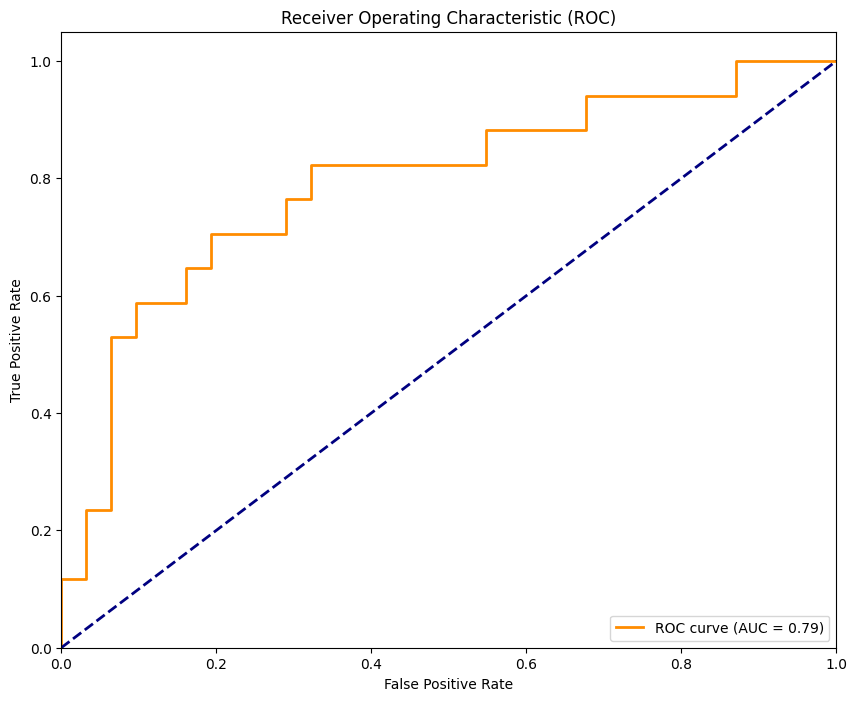

In [ ]:

# ROC Curve and AUC
predicted_probabilities = model.predict(test_data)
true_labels_positive = test_labels_onehot[:, 1]
fpr, tpr, thresholds = roc_curve(true_labels_positive, predicted_probabilities[:, 1])
roc_auc = auc(fpr, tpr)
# ROC Curve Plot
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix

predictions = model.predict(test_data)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels_onehot, axis=1)

cm = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(cm)

2/2 [==============================] - 0s 65ms/step
Confusion Matrix:
[[22  9]
 [ 4 13]]


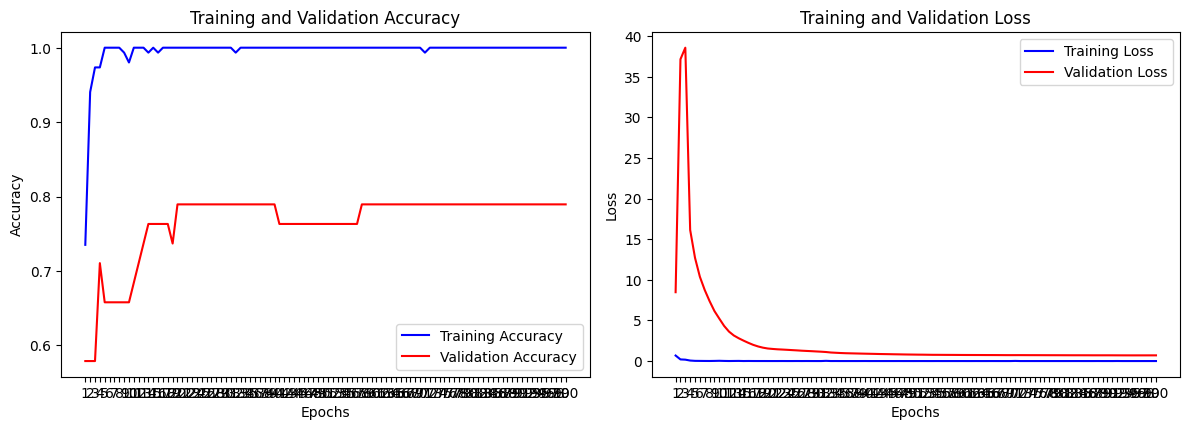

In [ ]:
# Extracting training history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_accuracy) + 1)

plt.figure(figsize=(12, 8))

# Accuracy plot
plt.subplot(2, 2, 1)
plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(epochs)  # Set the x-axis ticks explicitly

# Loss plot
plt.subplot(2, 2, 2)
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.xticks(epochs)  # Set the x-axis ticks explicitly

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import classification_report

predictions = model.predict(test_data)

predicted_labels = np.argmax(predictions, axis=1)

true_labels = np.argmax(test_labels_onehot, axis=1)

class_report = classification_report(true_labels, predicted_labels)

# Print the classification report
print("Classification Report:")
print(class_report)


2/2 [==============================] - 0s 66ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.71      0.77        31
           1       0.59      0.76      0.67        17

    accuracy                           0.73        48
   macro avg       0.72      0.74      0.72        48
weighted avg       0.76      0.73      0.73        48



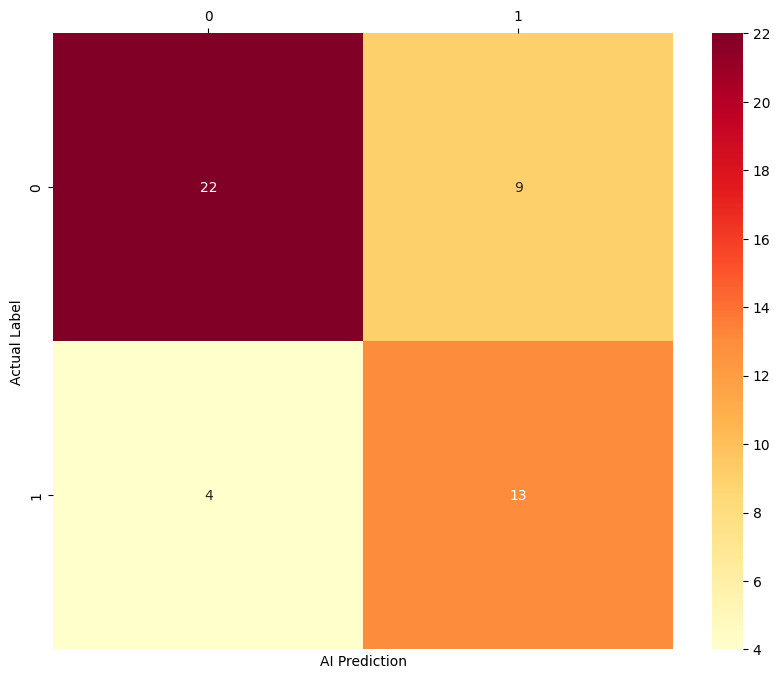

In [ ]:
# Karışıklık matrisini görselleştir
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
hm = sns.heatmap(cm, annot=True, fmt="d", cmap="YlOrRd", xticklabels=class_names, yticklabels=class_names)
hm.tick_params(labeltop=True, labelbottom=False, top=True, bottom=False)
plt.xlabel('AI Prediction')
plt.ylabel('Actual Label')
plt.show()